In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt

In [2]:
ticker = "IVV"
start_date = "2018-01-01"
end_date = "2025-07-01"

In [3]:
tickers = ["IVV", "VOO", "SPY", "VTI", "QQQ"]
data = yf.download(tickers, start=start_date, end=end_date)['Close'].dropna()
returns = data.pct_change().dropna()

/tmp/ipython-input-3-2751589459.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close'].dropna()
[*********************100%***********************]  5 of 5 completed


In [4]:
lw = LedoitWolf()
lw.fit(returns)
cov_matrix = lw.covariance_
shrunk_mean = lw.location_

In [5]:
print("Ledoit-Wolf Shrinkage Covariance Matrix:")
print(pd.DataFrame(cov_matrix, index=returns.columns, columns=returns.columns))

Ledoit-Wolf Shrinkage Covariance Matrix:
Ticker       IVV       QQQ       SPY       VOO       VTI
Ticker                                                  
IVV     0.000160  0.000181  0.000157  0.000158  0.000159
QQQ     0.000181  0.000239  0.000180  0.000181  0.000183
SPY     0.000157  0.000180  0.000157  0.000156  0.000158
VOO     0.000158  0.000181  0.000156  0.000159  0.000159
VTI     0.000159  0.000183  0.000158  0.000159  0.000164


In [6]:
print("\nShrunk Mean Vector:")
print(pd.Series(shrunk_mean, index=returns.columns))


Shrunk Mean Vector:
Ticker
IVV    0.000588
QQQ    0.000809
SPY    0.000585
VOO    0.000588
VTI    0.000565
dtype: float64


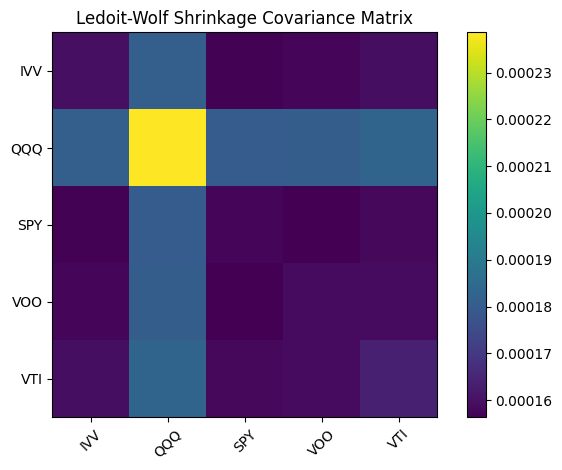

In [7]:
plt.imshow(cov_matrix, cmap='viridis')
plt.colorbar()
plt.title("Ledoit-Wolf Shrinkage Covariance Matrix")
plt.xticks(ticks=np.arange(len(returns.columns)), labels=returns.columns, rotation=45)
plt.yticks(ticks=np.arange(len(returns.columns)), labels=returns.columns)
plt.tight_layout()
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [9]:
class IVVSequenceDataset(Dataset):
    def __init__(self, ivv_returns, seq_len=30):
        self.X = []
        self.y = []
        for i in range(len(ivv_returns) - seq_len - 1):
            seq = ivv_returns[i:i+seq_len]
            next_day = ivv_returns[i+seq_len]
            label = int(next_day > 0)
            self.X.append(seq)
            self.y.append(label)
        self.X = torch.tensor(self.X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(self.y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ivv_returns = returns['IVV'].values
dataset = IVVSequenceDataset(ivv_returns)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

/tmp/ipython-input-9-3254762080.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  self.X = torch.tensor(self.X, dtype=torch.float32).unsqueeze(-1)


In [10]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, num_classes=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        logits = self.fc(out)
        return logits

def entropy_regularization(probs):
    entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
    return torch.mean(entropy)

def custom_loss(logits, targets, lambda_entropy=0.01):
    ce_loss = F.cross_entropy(logits, targets)
    probs = F.softmax(logits, dim=1)
    entropy_penalty = entropy_regularization(probs)
    return ce_loss - lambda_entropy * entropy_penalty

In [11]:
model = LSTMClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


for epoch in range(100):
    total_loss = 0
    for X_batch, y_batch in loader:
        logits = model(X_batch)
        loss = custom_loss(logits, y_batch, lambda_entropy=0.01)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 39.5674
Epoch 2, Loss: 39.5492
Epoch 3, Loss: 39.5439
Epoch 4, Loss: 39.5731
Epoch 5, Loss: 39.5341
Epoch 6, Loss: 39.5313
Epoch 7, Loss: 39.5345
Epoch 8, Loss: 39.5330
Epoch 9, Loss: 39.5401
Epoch 10, Loss: 39.5366
Epoch 11, Loss: 39.5257
Epoch 12, Loss: 39.5379
Epoch 13, Loss: 39.5258
Epoch 14, Loss: 39.5526
Epoch 15, Loss: 39.5369
Epoch 16, Loss: 39.5281
Epoch 17, Loss: 39.5329
Epoch 18, Loss: 39.5318
Epoch 19, Loss: 39.5345
Epoch 20, Loss: 39.5338
Epoch 21, Loss: 39.5283
Epoch 22, Loss: 39.5316
Epoch 23, Loss: 39.5315
Epoch 24, Loss: 39.5331
Epoch 25, Loss: 39.5305
Epoch 26, Loss: 39.5248
Epoch 27, Loss: 39.5269
Epoch 28, Loss: 39.5314
Epoch 29, Loss: 39.5281
Epoch 30, Loss: 39.5322
Epoch 31, Loss: 39.5424
Epoch 32, Loss: 39.5265
Epoch 33, Loss: 39.5335
Epoch 34, Loss: 39.5201
Epoch 35, Loss: 39.5246
Epoch 36, Loss: 39.5196
Epoch 37, Loss: 39.5337
Epoch 38, Loss: 39.5304
Epoch 39, Loss: 39.5292
Epoch 40, Loss: 39.5254
Epoch 41, Loss: 39.5343
Epoch 42, Loss: 39.5261
E

In [12]:
import cvxpy as cp
from sklearn.covariance import LedoitWolf

In [13]:
epsilon = 1e-2
cov_reg = cov_matrix + epsilon * np.eye(len(cov_matrix))
n = len(tickers)
w = cp.Variable(n)
entropy_epsilon = 1e-8
entropy = -cp.sum(cp.entr(w + entropy_epsilon))

ret = shrunk_mean @ w
risk = cp.quad_form(w, cov_reg)

constraints = [cp.sum(w) == 1, w >= 0]

lambda_entropy = 0.1

objective = cp.Minimize(risk  -  0.5 * ret)

problem = cp.Problem(objective, constraints)
problem.solve()

np.float64(0.0018553711021883407)

In [14]:
print("Optimal portfolio weights:")
for ticker, weight in zip(tickers, w.value):
    print(f"{ticker}: {weight:.4f}")

Optimal portfolio weights:
IVV: 0.1996
VOO: 0.2022
SPY: 0.1997
VTI: 0.1997
QQQ: 0.1989


In [15]:
weights = {
    'IVV': 0.1996,
    'VOO': 0.2022,
    'SPY': 0.1997,
    'VTI': 0.1997,
    'QQQ': 0.1989
}
selected_returns = returns[list(weights.keys())]
weights_array = np.array([weights[ticker] for ticker in selected_returns.columns])
portfolio_returns = selected_returns.dot(weights_array)
cumulative_portfolio = (1 + portfolio_returns).cumprod()
cumulative_ivv = (1 + returns['IVV']).cumprod()

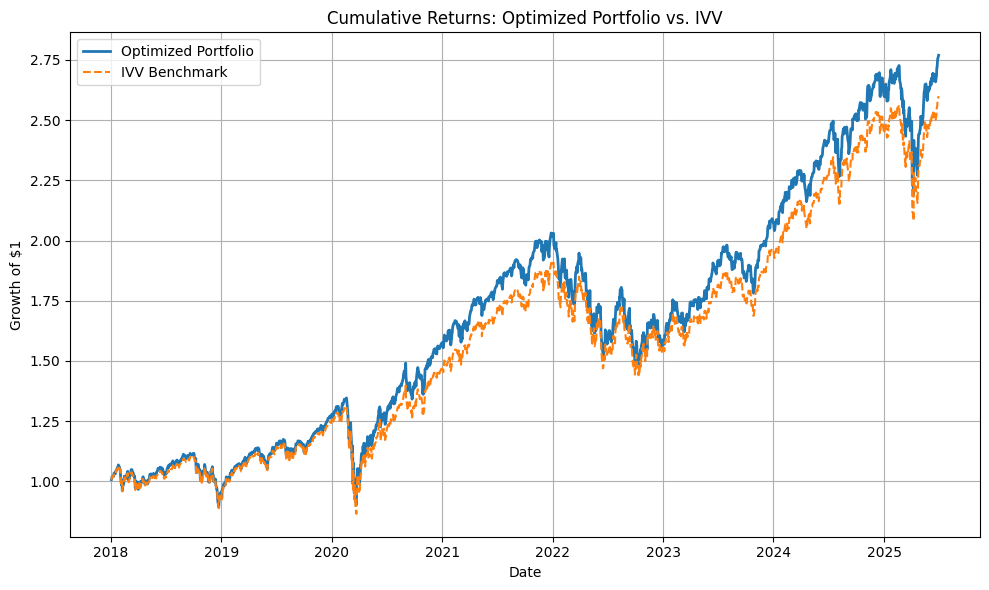

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_portfolio, label='Optimized Portfolio', linewidth=2)
plt.plot(cumulative_ivv, label='IVV Benchmark', linestyle='--')
plt.title('Cumulative Returns: Optimized Portfolio vs. IVV')
plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
returns = data.pct_change().dropna()
lw = LedoitWolf().fit(returns)
cov_matrix = lw.covariance_
mean_returns = returns.mean()
inv_cov = np.linalg.inv(cov_matrix)
weights = inv_cov @ mean_returns
weights /= np.sum(weights)
portfolio_returns = returns @ weights
cumulative_portfolio = (1 + portfolio_returns).cumprod()
cumulative_benchmark = (1 + returns['IVV']).cumprod()

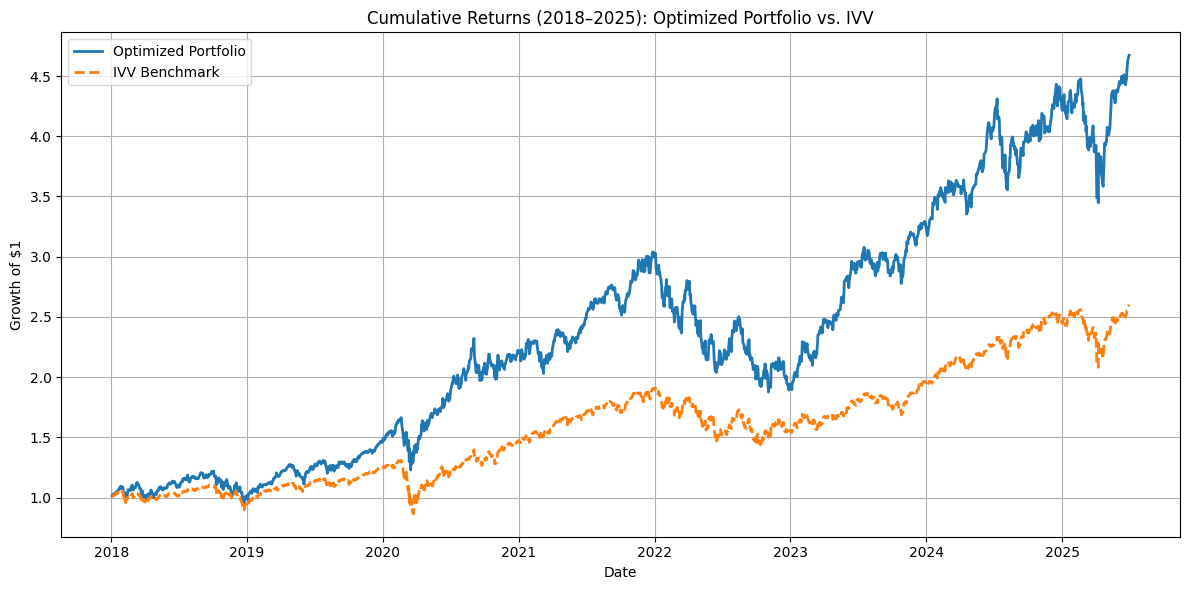

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(cumulative_portfolio, label='Optimized Portfolio', linewidth=2)
plt.plot(cumulative_benchmark, label='IVV Benchmark', linestyle='--', linewidth=2)
plt.title('Cumulative Returns (2018–2025): Optimized Portfolio vs. IVV')
plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()